In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Requirement

In [ ]:
# # For additional installation of libraries not included in the colab main library
# !pip install "library_name"
!pip install torch
!pip install barbar 
# !pip install tensorflow
# nicesin97@yonsei.ac.kr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
cd '/content/drive/My Drive/Colab Notebooks/MM'

/content/drive/My Drive/Colab Notebooks/MM


In [ ]:
import os
import time
import torch
import shutil
import pickle
import numpy as np
import torch.nn as nn # torch 기반 사용 
from barbar import Bar
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

# Configuration

In [ ]:
"""
Configuration for train_interface

You can check the essential information,
and if you want to change model structure or training method,
you have to change this file.
"""
#######################################################################
#                                 path                                #
#######################################################################
job_dir = './'  # 'FILE PATH for saving models'
chkpt_model = None  # 'FILE PATH (if you have pretrained model..)'
chkpt = str("EPOCH")
if chkpt_model is not None:
    chkpt_path = job_dir + chkpt_model + '/chkpt_' + chkpt + '.pt'

#######################################################################
#                         possible setting                            #
#######################################################################
# the list you can do
model_list = ['SPK_RECOG_MODEL', 'CRN']
loss_list = ['Categorical_CE', 'MSE', 'SDR', 'SI-SNR', 'SI-SDR']

# experiment number setting
expr_name = 'Spk_Recog'
DEVICE = 'cuda'  # if you want to run the code with 'cpu', change 'cpu'
#######################################################################
#                          Experimental setting                       #
#######################################################################
current_model = model_list[0]
current_loss = loss_list[0]

# hyper-parameters
max_epochs = 200
learning_rate = 0.0005
batch = 4   # 4, 8, 16, 32, 64

#######################################################################
#                         model information                           #
#######################################################################
fs = 16000
fft_len = 512           # 1024 # 2048
sam_sec = fft_len / fs
frm_samp = fs * (fft_len / fs)

rnn_layers = 2
rnn_input_size = 512
rnn_units = 128
#######################################################################
#                      setting error check                            #
#######################################################################
# if the setting is wrong, print error message

#######################################################################
#                           print setting                             #
#######################################################################
print('--------------------  C  O  N  F  I  G  ----------------------')
print('--------------------------------------------------------------')
print('MODEL INFO : {}'.format(current_model))
print('LOSS INFO : {}'.format(current_loss))
print('\nBATCH : {}'.format(batch))
print('LEARNING RATE : {}'.format(learning_rate))
print('--------------------------------------------------------------')
print('--------------------------------------------------------------\n')


--------------------  C  O  N  F  I  G  ----------------------
--------------------------------------------------------------
MODEL INFO : SPK_RECOG_MODEL
LOSS INFO : Categorical_CE

BATCH : 4
LEARNING RATE : 0.0005
--------------------------------------------------------------
--------------------------------------------------------------



# Feature Extract

In [ ]:
import librosa

n_spk = 26 #26개 오디오 파일을

# 임의의 오디오를 특정 길이가 되도록 padding 하는 함수
def pad_audio(audio):
    length = len(audio)
    return np.concatenate((audio, np.zeros((max_length-length))))


# 가장 긴 길이의 오디오를 찾는다.
# for문을 돌려서 모든 데이터의 길이를 length라는 리스트 안에 저장합니다
# 화자 22명에 대하여 수행
length = []
for s in range(0, n_spk, 1): 
    for n in range(1, 6, 1): #5번 -> 1부터 5까지 for문 돌음 
        (x,fs) = librosa.load('./data/speaker_data_wav_16k/'+str(s+1)+'_'+str(n) + '.wav')
        length.append(len(x))
        print(str(s)+'_'+str(n)+'번째 길이 탐색 완료!')

max_length = np.max(length) # length라는 리스트 안에서 가장 긴 오디오의 길이를 리턴합니다
print('가장 긴 오디오의 길이는 :', max_length/16000, 'seconds')

pickle.dump(max_length, open('./data/max_length', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

0_1번째 길이 탐색 완료!
0_2번째 길이 탐색 완료!
0_3번째 길이 탐색 완료!
0_4번째 길이 탐색 완료!
0_5번째 길이 탐색 완료!
1_1번째 길이 탐색 완료!
1_2번째 길이 탐색 완료!
1_3번째 길이 탐색 완료!
1_4번째 길이 탐색 완료!
1_5번째 길이 탐색 완료!
2_1번째 길이 탐색 완료!
2_2번째 길이 탐색 완료!
2_3번째 길이 탐색 완료!
2_4번째 길이 탐색 완료!
2_5번째 길이 탐색 완료!
3_1번째 길이 탐색 완료!
3_2번째 길이 탐색 완료!
3_3번째 길이 탐색 완료!
3_4번째 길이 탐색 완료!
3_5번째 길이 탐색 완료!
4_1번째 길이 탐색 완료!
4_2번째 길이 탐색 완료!
4_3번째 길이 탐색 완료!
4_4번째 길이 탐색 완료!
4_5번째 길이 탐색 완료!
5_1번째 길이 탐색 완료!
5_2번째 길이 탐색 완료!
5_3번째 길이 탐색 완료!
5_4번째 길이 탐색 완료!
5_5번째 길이 탐색 완료!
6_1번째 길이 탐색 완료!
6_2번째 길이 탐색 완료!
6_3번째 길이 탐색 완료!
6_4번째 길이 탐색 완료!
6_5번째 길이 탐색 완료!
7_1번째 길이 탐색 완료!
7_2번째 길이 탐색 완료!
7_3번째 길이 탐색 완료!
7_4번째 길이 탐색 완료!
7_5번째 길이 탐색 완료!
8_1번째 길이 탐색 완료!
8_2번째 길이 탐색 완료!
8_3번째 길이 탐색 완료!
8_4번째 길이 탐색 완료!
8_5번째 길이 탐색 완료!
9_1번째 길이 탐색 완료!
9_2번째 길이 탐색 완료!
9_3번째 길이 탐색 완료!
9_4번째 길이 탐색 완료!
9_5번째 길이 탐색 완료!
10_1번째 길이 탐색 완료!
10_2번째 길이 탐색 완료!
10_3번째 길이 탐색 완료!
10_4번째 길이 탐색 완료!
10_5번째 길이 탐색 완료!
11_1번째 길이 탐색 완료!
11_2번째 길이 탐색 완료!
11_3번째 길이 탐색 완료!
11_4번째 길이 탐색 완료!
11_5번째 길이 탐색 완료!
12_1번째 길이 탐색 완료!
12_2번째 길이 탐색 

In [ ]:
mode = 'test'      # train / devel / test 이 순으로 
if mode == 'train':
    start_idx = 1
    end_idx = 5
elif mode == 'devel':
    start_idx = 5
    end_idx = 6

# 각 speaker들의 1~4번 음원에 대하여 train dataset으로 사용.
# train_mfcc_features / train_labels로 저장
print('Feature extraction for training data...')
data_train = []
refer_train = []
for s in range(0, n_spk, 1):
    for n in range(start_idx, end_idx, 1):
        (x, fs) = librosa.load('./data/speaker_data_wav_16k/' + str(s+1) + '_' + str(n) + '.wav')
        x = pad_audio(x)
        mfcc = librosa.feature.mfcc(y=x, sr=fs, n_mfcc=13)
        mfccs = mfcc - np.reshape(np.mean(mfcc, 1), (13, 1))  # Remove DC components # 13 x frame_size
        mfccs = np.transpose(mfccs)
        # labels = np.zeros((mfccs.shape[0], 22))
        # labels[:, s - 1] = 1
        labels = np.ones((1,))*s           # [1, 1]
        data_train.append(np.float16(mfccs))
        refer_train.append(np.float16(labels))      # [Batch, 1]
        print(str(s) + '_' + str(n) + '번째 완료!')

pickle.dump(np.array(data_train), open('./data/mfcc_features_' + str(mode), 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(np.array(refer_train), open('./data/labels_' + str(mode), 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

Feature extraction for training data...
0_5번째 완료!
1_5번째 완료!
2_5번째 완료!
3_5번째 완료!
4_5번째 완료!
5_5번째 완료!
6_5번째 완료!
7_5번째 완료!
8_5번째 완료!
9_5번째 완료!
10_5번째 완료!
11_5번째 완료!
12_5번째 완료!
13_5번째 완료!
14_5번째 완료!
15_5번째 완료!
16_5번째 완료!
17_5번째 완료!
18_5번째 완료!
19_5번째 완료!
20_5번째 완료!
21_5번째 완료!
22_5번째 완료!
23_5번째 완료!
24_5번째 완료!
25_5번째 완료!


# 훈련 데이터 확인

In [ ]:
# Load data (Training data & Validation data)
print('Load data...')
X_train = pickle.load(open('./data/mfcc_features_train', 'rb'))
Y_train = pickle.load(open('./data/labels_train', 'rb'))

X_valid = pickle.load(open('./data/mfcc_features_devel', 'rb'))
Y_valid = pickle.load(open('./data/labels_devel', 'rb'))


# Validation용 데이터 만들기 (training set의 20%를 validation set으로 설정)
print(X_train.shape)
print(X_valid.shape)

Load data...
(104, 1256, 13)
(26, 1256, 13)


# Dataloader

In [ ]:
# clip padding
max_length = pickle.load(open('./data/max_length', 'rb'))

# Reshape
X_train = np.transpose(X_train, (0, 2, 1))
X_valid = np.transpose(X_valid, (0, 2, 1))


def create_dataloader(mode):
    if mode == 'train':
        return DataLoader(
            dataset=Wave_Dataset(mode),
            batch_size=batch,
            shuffle=True,
            num_workers=0,
            pin_memory=True,
            drop_last=True,
            sampler=None
        )
    elif mode == 'devel':
        return DataLoader(
            dataset=Wave_Dataset(mode),
            batch_size=batch, shuffle=False, num_workers=0
        )


class Wave_Dataset(Dataset):
    def __init__(self, mode):
        # load data
        if mode == 'train':
            print('<Training dataset>')
            print('Load the data...')
            self.input = X_train
            self.target = Y_train
        elif mode == 'devel':
            print('<Validation dataset>')
            print('Load the data...')
            self.input = X_valid
            self.target = Y_valid

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
            inputs = self.input[idx]
            targets = self.target[idx]

            # transform to torch from numpy
            inputs = torch.from_numpy(inputs)
            targets = torch.from_numpy(targets)
            return inputs, targets[0]

#모델 설계

학습 데이터는 모두 준비되었고, 이제 학습을 위한 모델을 설계해보겠습니다.

In [ ]:
class SPK_RECOG_MODEL( nn.Module ):
    def __init__(self):
        super(SPK_RECOG_MODEL, self).__init__()

        self.conv_1st_layer = nn.Conv1d(13, 26, kernel_size=3, padding=1, stride=2, dilation=1)  # (B, 13, 1229) --> (B, 26, 628)
        self.normalized_1st_layer = nn.BatchNorm1d(26) #네트워크 연산 결과가 원하는 방향의 분포대로 흘러가기 위해 넣었습니다. 즉, activation function 인 PReLU이 적용되어 분포가 달라지기 전에 적용해야된다. 
        self.act_1st_layer = nn.PReLU() #활성화 함수로 제일 적합        
        self.pool_1st_layer = nn.MaxPool1d(kernel_size = 2, stride = 2) # (B, 26, 314) 정규화 기법 이후에 우리가 원하는 값들만 빠르게 뽑아내기 때문에 시간 효율과 정확도 면에서 좋아졌다. 
        
        self.conv_2nd_layer = nn.Conv1d(26, 78, kernel_size=3, padding=1, stride=2, dilation=1)  # (B, 26, 314) --> (B, 78, 157) 
        self.normalized_2nd_layer = nn.BatchNorm1d(78) #네트워크 연산 결과가 원하는 방향의 분포대로 흘러가기 위해 넣었습니다.
        self.act_2nd_layer = nn.PReLU() #활성화 함수로 제일 적합
        self.pool_2nd_layer = nn.MaxPool1d(kernel_size = 2) # (B, 78, 157) --> (B, 78, 78) 입력벡터에서 특정 구간마다 값을 골라 벡터를 구성한 후 반환합니다(2개 뽑아내서 제일 큰 1개 반환). 정규화 기법 이후에 우리가 원하는 값들만 빠르게 뽑아내기 때문에 시간 효율과 정확도 면에서 좋아졌다. 

        self.conv_3rd_layer = nn.Conv1d(78, 52, kernel_size=3, padding=2, stride=2, dilation=1)  # (B, 78, 78) --> (B, 52, 40) 
        self.normalized_3nd_layer = nn.BatchNorm1d(52)#네트워크 연산 결과가 원하는 방향의 분포대로 흘러가기 위해 넣었습니다.
        self.act_3rd_layer = nn.PReLU()#활성화 함수로 제일 적합 
        self.dropout = nn.Dropout(0.5) #과적합을 방지하기 위해서 학습 시에 지정된 비율만큼 임의의 입력 뉴런(1차원)을 제외시킵니다. 위에는 안 넣은 이유는 안 그래도 데이터 표본도 적은데 처음부터 이렇게 하면 데이터 수가 부족해서 훈련을 못한 데이터가 생길 수도 있으므로
        self.maxpool = nn.MaxPool1d(kernel_size=2 , stride = 2) # (B, 52, 40) --> (B, 52, 20)  


        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1040, 512) #3140 ,512
        self.act_fc1 = nn.PReLU()
        
        self.fc2 = nn.Linear(512, 256) #1024 256
        self.act_fc2 = nn.PReLU()
        
        self.fc3 = nn.Linear(256, 26)

    def forward(self, x):

        # CNN layers
        x1 = self.conv_1st_layer(x)
        x1 = self.normalized_1st_layer(x1) 
        x1 = self.act_1st_layer(x1)             
        x1 = self.pool_1st_layer(x1) 
        
        x2 = self.conv_2nd_layer(x1)
        x2 = self.normalized_2nd_layer(x2) 
        x2 = self.act_2nd_layer(x2)        
        x2 = self.pool_2nd_layer(x2) 
        
        x3 = self.conv_3rd_layer(x2)
        x3 = self.normalized_3nd_layer(x3)       
        x3 = self.act_3rd_layer(x3)
        x3 = self.dropout(x3)
        x3 = self.maxpool(x3)         

        # Flattening
        x_flat = self.flatten(x3)

        # FCN layers
        x4 = self.fc1(x_flat)
        x4 = self.act_fc1(x4)

        x5 = self.fc2(x4)
        x5 = self.act_fc2(x5)

        x6 = self.fc3(x5)

        return x6

# Trainer

In [ ]:
#######################################################################
#                             For train                               #
#######################################################################
def model_train(model, optimizer, train_loader, DEVICE, criterion):
    # initialization
    train_loss = 0
    batch_num = 0

    # train
    model.train()
    for inputs, labels in Bar( train_loader ):
        batch_num += 1

        # to cuda
        inputs = inputs.float().to(DEVICE)
        labels = labels.float().to(DEVICE)  # labels.shape [B]

        est = model(inputs)  # est.shape [B, 26]
        loss = F.cross_entropy(est, labels.long())

        # # if you want to check the scale of the loss
        # print('loss: {:.4}'.format(loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss
    train_loss /= batch_num

    return train_loss


#######################################################################
#                           For validation                            #
#######################################################################
def model_validate(model, validation_loader, dir_to_save, epoch, DEVICE, criterion):
    # initialization
    validation_loss = 0
    correct = 0
    batch_num = 0

    model.eval()
    with torch.no_grad():
        for inputs, labels in Bar( validation_loader ):
            batch_num += 1

            # to cuda
            inputs = inputs.float().to(DEVICE)
            labels = labels.float().to(DEVICE)

            est = model(inputs)                         # est.shape = [Batch, Num_of_Spk] (batch, 22)
            loss = F.cross_entropy(est, labels.long())

            # Calculate Accuracy
            ans, est_idx = torch.max(est, 1)
            correct += est_idx.eq(labels).sum().item()  #

            validation_loss += loss

        validation_loss /= batch_num
        valid_acc = 100. * correct / len(validation_loader.dataset)

        return validation_loss, valid_acc


# Train Interface

모델 훈련

이제, 학습을 시작합니다.

Epoch은 전체 데이터에 대한 반복 학습 횟수입니다.

학습 도중 각 단계마다 오차(loss)와 정확도(acc)가 출력됩니다.

학습이 진행되는 동안 이 둘이 어떻게 변하는지 확인합니다.

매 Epoch마다 체크 포인트를 발동하여 weights정보를 기록합니다. 가장 validation accuracy가 높았을 때의 weights를 저장하기 위합니다.


In [ ]:
###############################################################################
#                        Helper function definition                           #
###############################################################################
# Write training related parameters into the log file.
def write_status_to_log_file(fp, total_parameters):
    fp.write('%d-%d-%d %d:%d:%d\n' %
             (time.localtime().tm_year, time.localtime().tm_mon,
              time.localtime().tm_mday, time.localtime().tm_hour,
              time.localtime().tm_min, time.localtime().tm_sec))
    fp.write('total params   : %d (%.2f M, %.2f MBytes)\n' %
             (total_parameters,
              total_parameters / 1000000.0,
              total_parameters * 4.0 / 1000000.0))


# Calculate the size of total network.
def calculate_total_params(our_model):
    total_parameters = 0
    for variable in our_model.parameters():
        shape = variable.size()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim
        total_parameters += variable_parameters

    return total_parameters


###############################################################################
#         Parameter Initialization and Setting for model training             #
###############################################################################
# Set device
DEVICE = torch.device('cuda') # if you want to run the code with 'cpu', change 'cpu'

# Set model
model = SPK_RECOG_MODEL().to(DEVICE)

# Set optimizer and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_params = calculate_total_params(model)

###############################################################################
#                        Confirm model information                            #
###############################################################################
print('%d-%d-%d %d:%d:%d\n' %
      (time.localtime().tm_year, time.localtime().tm_mon,
       time.localtime().tm_mday, time.localtime().tm_hour,
       time.localtime().tm_min, time.localtime().tm_sec))
print('total params   : %d (%.2f M, %.2f MBytes)\n' %
      (total_params,
       total_params / 1000000.0,
       total_params * 4.0 / 1000000.0))

###############################################################################
#                              Create Dataloader                              #
###############################################################################
train_loader = create_dataloader(mode='train')
validation_loader = create_dataloader(mode='devel')

criterion = nn.BCEWithLogitsLoss(torch.ones(22)).to(DEVICE)
# criterion = nn.CrossEntropyLoss().to(DEVICE)

###############################################################################
#                        Set a log file to store progress.                    #
#               Set a hps file to store hyper-parameters information.         #
###############################################################################
if chkpt_model is not None:  # Load the checkpoint
    print('Resuming from checkpoint: %s' % chkpt_path)

    # Set a log file to store progress.
    dir_to_save = job_dir + chkpt_model

    checkpoint = torch.load(chkpt_path)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_start_idx = checkpoint['epoch'] + 1
    acc_vali_total = np.load(str(dir_to_save + '/acc_vali_total.npy'))
else:  # First learning
    print('Starting new training run...')
    epoch_start_idx = 1
    acc_vali_total = np.zeros(max_epochs)

    # Set a log file to store progress.
    dir_to_save = job_dir + expr_name + '_%d.%d' % (time.localtime().tm_mon,
                                                           time.localtime().tm_mday) + '_%s' % current_model + '_%s' % current_loss

# make the file directory
if not os.path.exists(dir_to_save):
    os.mkdir(dir_to_save)

# logging
log_fname = str(dir_to_save + '/log.txt')
fp = open(log_fname, 'w')
write_status_to_log_file(fp, total_params)


###############################################################################
###############################################################################
#                             Main program start !!                           #
###############################################################################
###############################################################################

###############################################################################
#                                    Train                                    #
###############################################################################
acc_valid_total = np.zeros(max_epochs)

for epoch in range(epoch_start_idx, max_epochs):
        start_time = time.time()
        # Training
        train_loss = model_train(model, optimizer, train_loader, DEVICE, criterion)

        # save checkpoint file to resume training
        save_path = str(dir_to_save + '/' + ('chkpt_%d.pt' % epoch))

        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch
        }, save_path)

        # Validation
        valid_loss, valid_acc = \
        model_validate(model, validation_loader, dir_to_save, epoch, DEVICE, criterion)

        print('Epoch [{}] | T {:.6f} | V {:.4} V_ACC {:.2f} takes {:.2f} seconds\n'
                  .format(epoch, train_loss, valid_loss, valid_acc, time.time() - start_time))
        # log file save
        fp.write('Epoch [{}] | T {:.6f} | V {:.4} V_ACC {:.2f} takes {:.2f} seconds\n'
                     .format(epoch, train_loss, valid_loss, valid_acc, time.time() - start_time))

        acc_valid_total[epoch - 1] = valid_acc
        np.save(str(dir_to_save + '/acc_valid_total.npy'), acc_valid_total)


fp.close()
print('Training has been finished.')

# Copy optimum model that has minimum MSE.
print('Save optimum models...')
max_index = np.argmax(acc_valid_total)
print('Maximum Accuracy is at ' + str(max_index + 1) + '.')
src_file = str(dir_to_save + '/' + ('chkpt_%d.pt' % (max_index + 1)))
tgt_file = str(dir_to_save + '/chkpt_opt.pt')
shutil.copy(src_file, tgt_file)

2022-6-30 9:35:0

total params   : 690741 (0.69 M, 2.76 MBytes)

<Training dataset>
Load the data...
<Validation dataset>
Load the data...
Starting new training run...
104/104: [==============================>.] - ETA 0.7s
26/26: [===========================>....] - ETA 0.0s
Epoch [1] | T 3.340993 | V 3.101 V_ACC 23.08 takes 0.94 seconds

104/104: [==============================>.] - ETA 0.0s
26/26: [===========================>....] - ETA 0.0s
Epoch [2] | T 2.696152 | V 2.435 V_ACC 34.62 takes 0.21 seconds

104/104: [==============================>.] - ETA 0.0s
26/26: [===========================>....] - ETA 0.0s
Epoch [3] | T 1.665870 | V 1.699 V_ACC 50.00 takes 0.22 seconds

104/104: [==============================>.] - ETA 0.0s
26/26: [===========================>....] - ETA 0.0s
Epoch [4] | T 0.724775 | V 1.144 V_ACC 76.92 takes 0.22 seconds

104/104: [==============================>.] - ETA 0.0s
26/26: [===========================>....] - ETA 0.0s
Epoch [5] | T 0.214705 | V 0.957

'./Spk_Recog_6.30_SPK_RECOG_MODEL_Categorical_CE/chkpt_opt.pt'

# 모델 평가 및 결과 분석

다음은 훈련 중 loss와 accuracy가 어떻게 변했는지를 그래프로 나타내보겠습니다.

학습 과정이 길다면 한 눈에 살펴볼 수 있는 좋은 방법입니다.

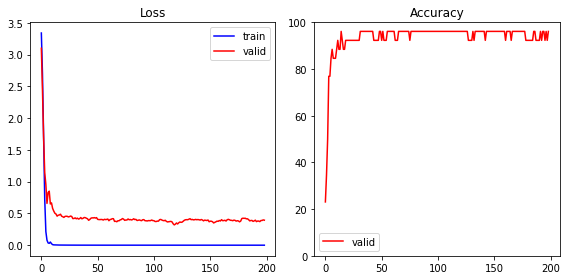

In [ ]:
fp = open('./Spk_Recog_6.30_SPK_RECOG_MODEL_Categorical_CE/log.txt', 'r')
line = fp.readlines()

train_loss = np.zeros((len(line)-2, ))
valid_loss = np.zeros((len(line)-2, ))
valid_acc = np.zeros((len(line)-2, ))

for idx in range(2, len(line)):
    train_loss[idx-2] = line[idx].split(' ')[4]
    valid_loss[idx-2] = line[idx].split(' ')[7]
    valid_acc[idx-2] = line[idx].split(' ')[9]

fp.close()


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(train_loss, 'b', label='train')
plt.plot(valid_loss, 'r', label='valid')
# plt.xlim([0, 100]); plt.ylim([0, 5])
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(valid_acc, 'r', label='valid')
plt.ylim([0, 100]); # plt.xlim([0, 100])
plt.legend()
plt.tight_layout()
plt.show()

# [라벨링 순서]

# '1'     , '2'     , '3'     , '4'     , '5'     , '6'     , '7'     , '8'     , '9'     , '10'    , '11'    , '12'    ,'13'    , '14'    , '15'    , '16'    , '17'    , '18'    , '19'    , '20'    '21'    , '22',   '23',   '24', '25',  '26'
# '박경원', '김동현', '이수연',    '정재원',  '박성환',  '심형준',   '유지현',   '장종빈',  '임현우',   '안제호',   '박세진',  '이민구', '김장현',  '류승현',  '고무현',   '심대한',   '김영민',   '정성현',  '임태윤',  '진형민',   '김동원',   '변준', '박찬진', '차재빈', '허준영','신승민(조교)'


Confusion matrix를 그려봅니다. (Training & Validation)

Confusion matrix는 실제 정답과 예측한 정답 사이의 관계를 나타낸 표입니다.

Load data...


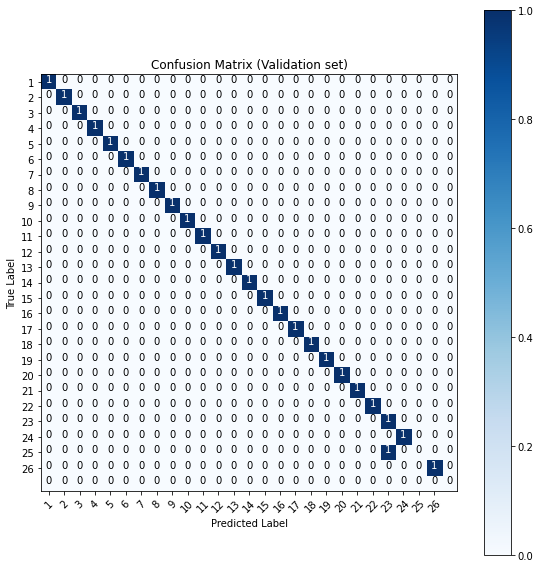

In [ ]:
# '1'     , '2'     , '3'     , '4'     , '5'     , '6'     , '7'     , '8'     , '9'     , '10'    , '11'    , '12'    , '13'    , '14'    , '15'    , '16'    , '17'    , '18'    , '19'    , '20'    , '21'    , '22'     
# '박경원', '김동현', '이수연', '정재원', '박성환', '심형준', '유지현', '장종빈', '임현우', '안제호', '박세진', '이민구', '김장현', '류승현', '고무현', '심대한', '김영민', '정성현', '임태윤', '진형민', '김동원', '변준(조교)'
import itertools
from sklearn.metrics import classification_report, confusion_matrix


# Check point Settings
CHECK_POINT_PATH = str('./Spk_Recog_6.30_SPK_RECOG_MODEL_Categorical_CE/chkpt_199.pt')
checkpoint = torch.load(CHECK_POINT_PATH)


# Model Load
model = SPK_RECOG_MODEL().to(DEVICE)
model.load_state_dict(checkpoint['model'])
model.eval()

# Load data (Validation data)
print('Load data...')
X_valid = pickle.load(open('./data/mfcc_features_devel', 'rb'))
Y_valid = pickle.load(open('./data/labels_devel', 'rb'))


X_valid = np.transpose(X_valid, (0, 2, 1))
X_valid = torch.from_numpy(X_valid).float().to(DEVICE)


y_pred = model(X_valid).to('cpu').detach().numpy()
y_pred = np.argmax(y_pred, axis=1)
y_gt = Y_valid.squeeze(1)

# '1'     , '2'     , '3'     , '4'     , '5'     , '6'     , '7'     , '8'     , '9'     , '10'    , '11'    , '12'    ,
# '박경원', '김동현', '이수연',    '정재원',  '박성환',  '심형준',   '유지현',   '장종빈',  '임현우',   '안제호',   '박세진',  '이민구',
# '13'    , '14'    , '15'    , '16'    , '17'    , '18'    , '19'    , '20'    , '21'    , '22',   '23',   '24',   '25',   '26'
#'김장현',  '류승현',  '고무현',   '심대한',   '김영민',   '정성현',  '임태윤',  '진형민',   '김동원',   '변준', '박찬진', '차재빈', '허준영','신승민(조교)'
plt.figure(figsize=(8, 8))
cm2 = confusion_matrix(y_gt, y_pred, labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21, 22, 23, 24, 25, 26])
plt.imshow(cm2, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation set)")
plt.colorbar()
tick_marks = np.arange(26)
plt.xticks(tick_marks, ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26'], rotation=45)
plt.yticks(tick_marks, ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26'])
thresh2 = cm2.max()/2.
normalize = False
fmt = '.2f' if normalize else 'd'
for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
  plt.text(j, i, format(cm2[i,j], fmt), horizontalalignment="center", color="white" if cm2[i, j] > thresh2 else "black")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()